# Predikce výsledku bankovního telemarketingu

Popis úlohy:

Vybudovat klasifikační model, který na základě informací o zákazníkovi a telefonátu, rozhodne, jestli daný zákazník nabídku přijme nebo ne.

Zdroj dat:

https://archive.ics.uci.edu/dataset/222/bank+marketing

[Moro et al., 2011] S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 
  In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. EUROSIS.

  Available at: [pdf] http://hdl.handle.net/1822/14838
                [bib] http://www3.dsi.uminho.pt/pcortez/bib/2011-esm-1.txt

## Předzpracování datasetu

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from dtreeviz.trees import dtreeviz
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from mlxtend.plotting import plot_decision_regions 
from sklearn import tree
import plotly.express as px

rd_seed = 40

### Načtení datasetu a popis příznaků:

In [2]:
data = pd.read_csv("bank-full.csv", sep=';')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Data klienta banky:

- 0 - age = věk, numerický
- 1 - job = zaměstnání, kategorický: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services"
- 2 - marital = rodinný stav, kategorický: "married","divorced","single"; 
  - pozn: "divorced" znamená rozvedený nebo ovdovělý
- 3 - education = vzdělání - kategorický:  "unknown","secondary","primary","tertiary"
- 4 - default = nesplacený úvěr - "yes","no"
- 5 - balance = zůstatek - průměrný roční zůstatek v eurech - numerický
- 6 - housing = hypotéka - má hypotéku  "yes", "no"
- 7 - loan = půjčka - má osobní půjčku "yes", "no" 

Vztahující se k poslednímu kontaktu aktuální kampaně:

- 8 - contact = kontakt - způsob kontaktování - kategorický: "unknown", "telephone", "cellular"
- 9 - day = den - den posledního kontaktu, den v měsíci - numerický
- 10 - month = měsíc - měsíc posledního kontatku -  kategorický: "jan", "feb", "mar", ..., "nov", "dec"
- 11 - duration = délka - délka trvání rozhovoru v sekundách

Další příznaky:

- 12 - campaign - počet kontaktování během této kampaně pro konkrétního klienta - numerický
- 13 - pdays - počet dnů od posledního kontaktování během předchozí kampaně - numerický, -1 == klient nebyl kontaktován
- 14 - previous - počet kontaktování provedené před současnou kampaní
- 15 - poutcome - výsledek předchozí kampaně, kategorický: "unknown","other","failure","success"

Vysvětlovaná proměnná: 
- 16 - y - podepsal klient termínovaný vklad "yes", "no"

Neznáme hodnoty jsou v datasetu značeny hodnotou unknown

### Rozdělení dat na trénovací, validační a testovací množinu

Rozdělím data na trénovací, validační a testovací množinu v poměru:

- 70 % - trénovací 

- 15 % - validační

- 15 % - testovací 

In [3]:
def splitData(data, y_collumn):
    Xdata = data.drop(y_collumn, axis=1)
    ydata = data[y_collumn]
    Xtrain, Xtest, ytrain, ytest = train_test_split(
        Xdata, ydata, test_size=0.3, random_state=rd_seed
    )
    Xval, Xtest, yval, ytest = train_test_split(
        Xtest, ytest, test_size=0.5, random_state=rd_seed
    )
    return Xtrain, ytrain, Xval, yval, Xtest, ytest

Xtrain, ytrain, Xval, yval, Xtest, ytest = splitData(data, 'y')

In [4]:
display(Xtrain.head())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
23363,31,management,single,tertiary,no,347,yes,no,cellular,27,aug,59,6,-1,0,unknown
7144,43,management,married,unknown,no,5172,yes,no,unknown,29,may,57,3,-1,0,unknown
31982,34,management,married,tertiary,no,1116,yes,no,cellular,13,apr,120,1,262,5,failure
11389,38,management,married,tertiary,yes,-1007,yes,yes,unknown,19,jun,71,1,-1,0,unknown
22242,34,management,single,tertiary,no,0,no,no,cellular,21,aug,129,4,-1,0,unknown


### Analýza kategorických příznaků

Před samotnou analýzou nejprve převedu na textový kód měsíce na odpovídající číslo 1-12. Potom všechny sloupce typu object převedu na categorický typ.

In [5]:
def to_cat(data):
    for column in data.columns:
        if data[column].dtype == object:
            data[column] = data[column].astype("category")
    return data

def map_months(data):
    month_mapping = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
    data['month'] = data['month'].map(month_mapping)
    return data

In [6]:
Xtrain = map_months(Xtrain)
Xtrain = to_cat(Xtrain)

Pro všechny kategorické příznaky vykreslím sloupcové grafy zobrazující počet jednotlivých kategoríí v daném sloupci.

In [7]:
def countplot_format(data, col=None):
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.countplot(x=col, data=data, edgecolor='black')
    plt.title(f'Count of {col}')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

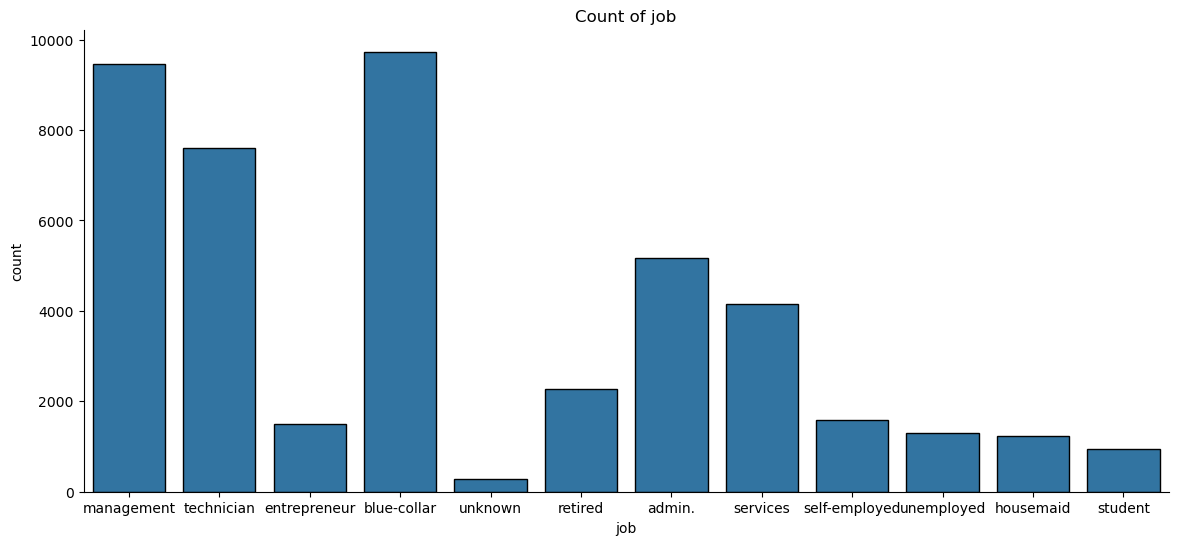

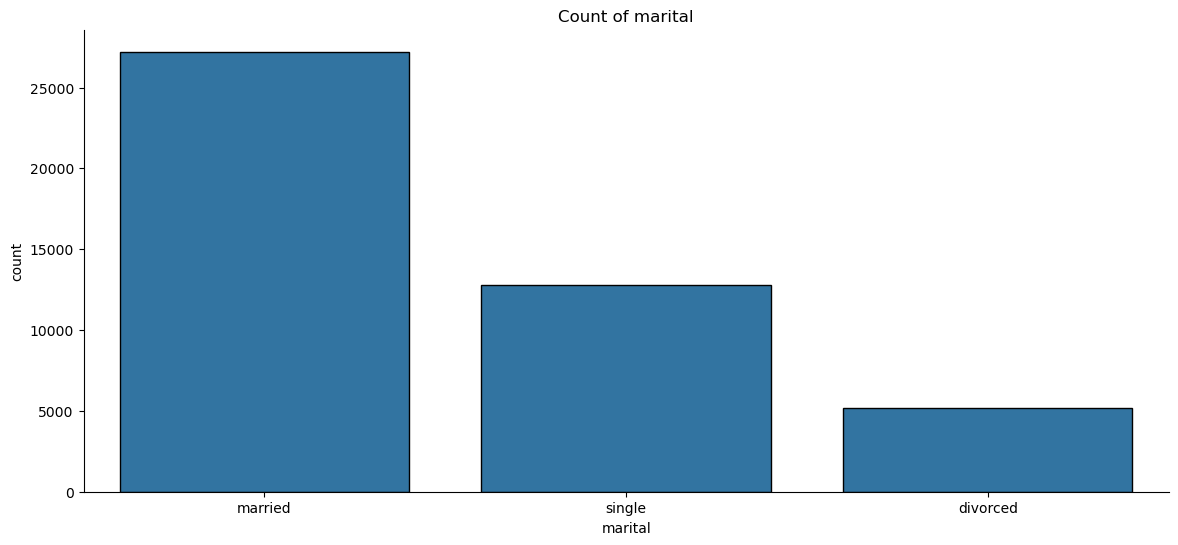

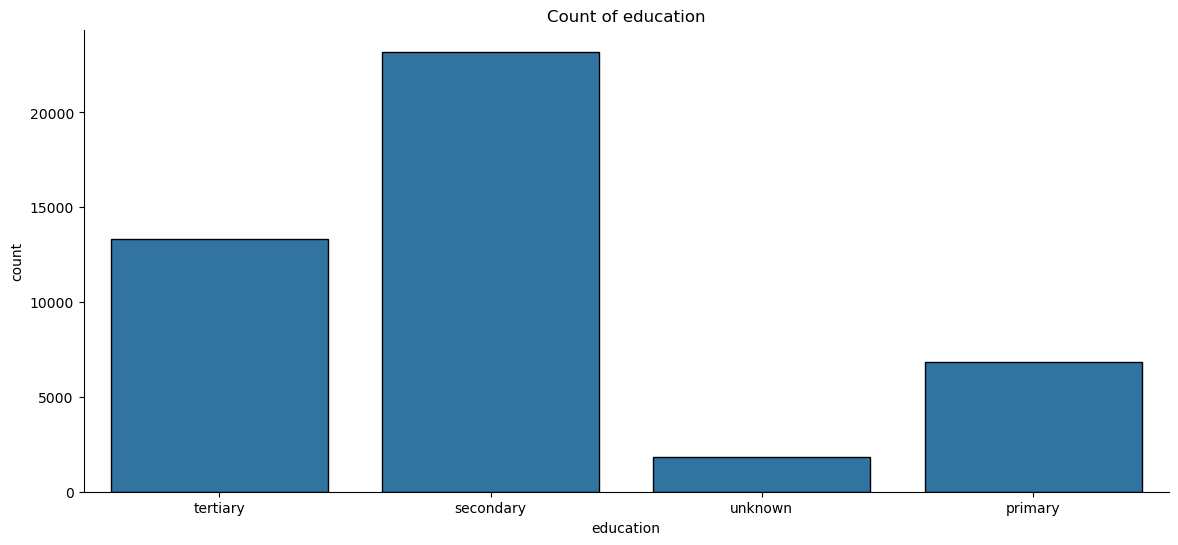

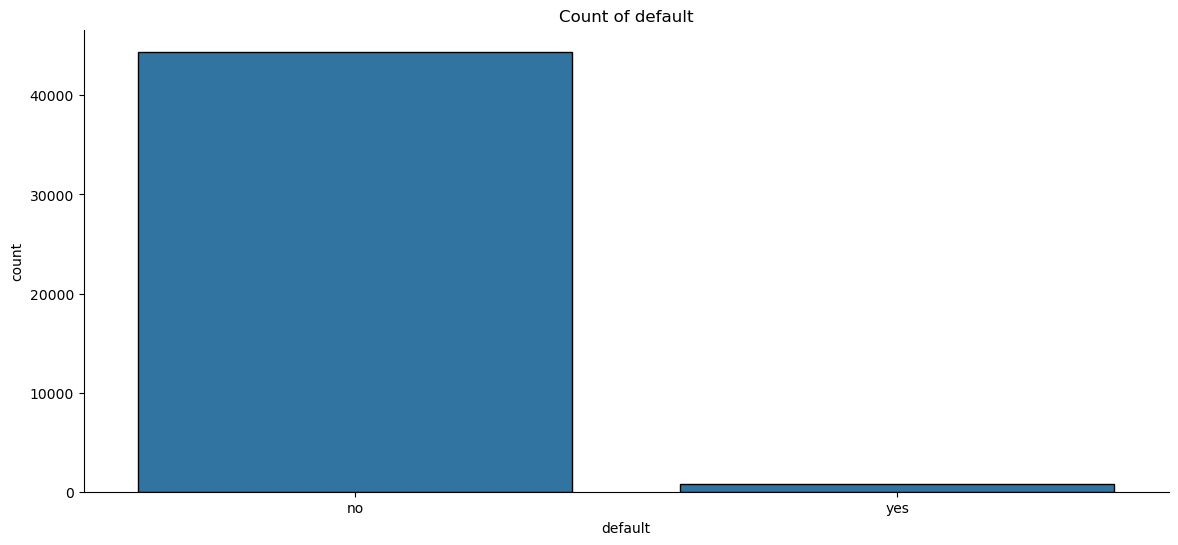

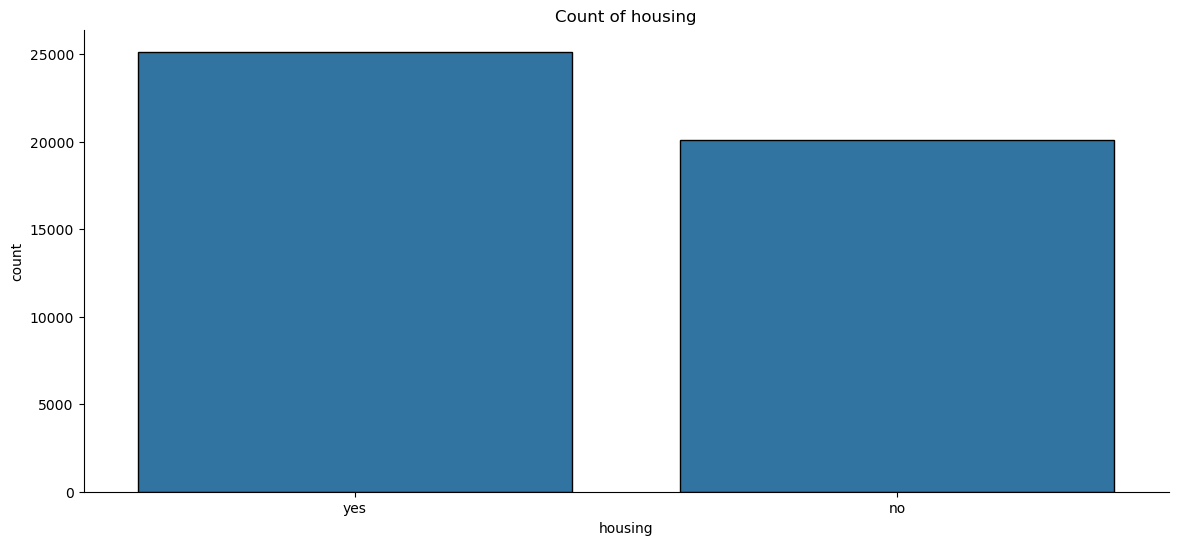

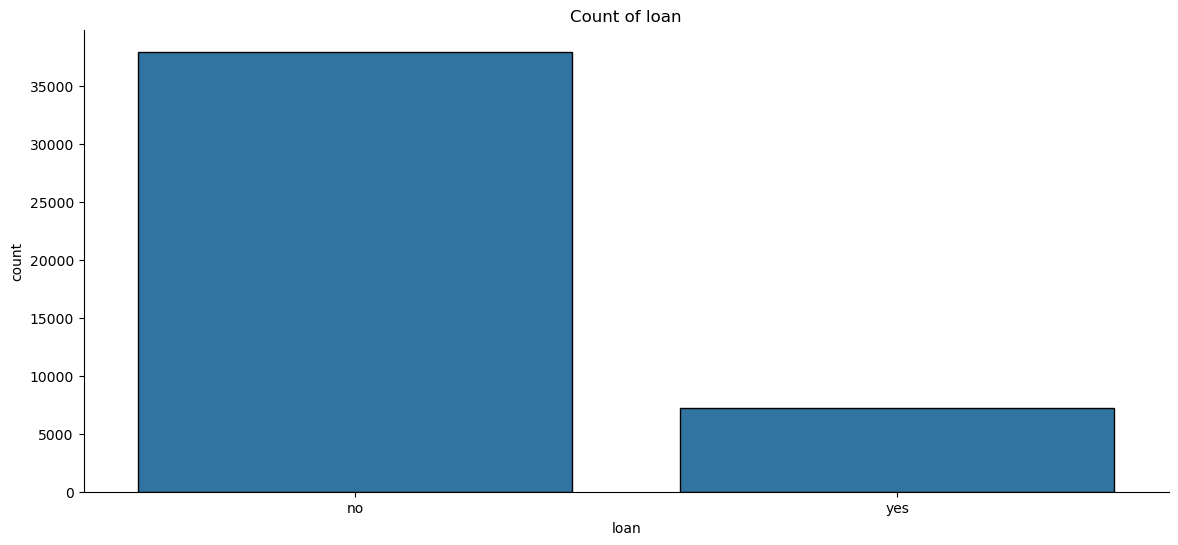

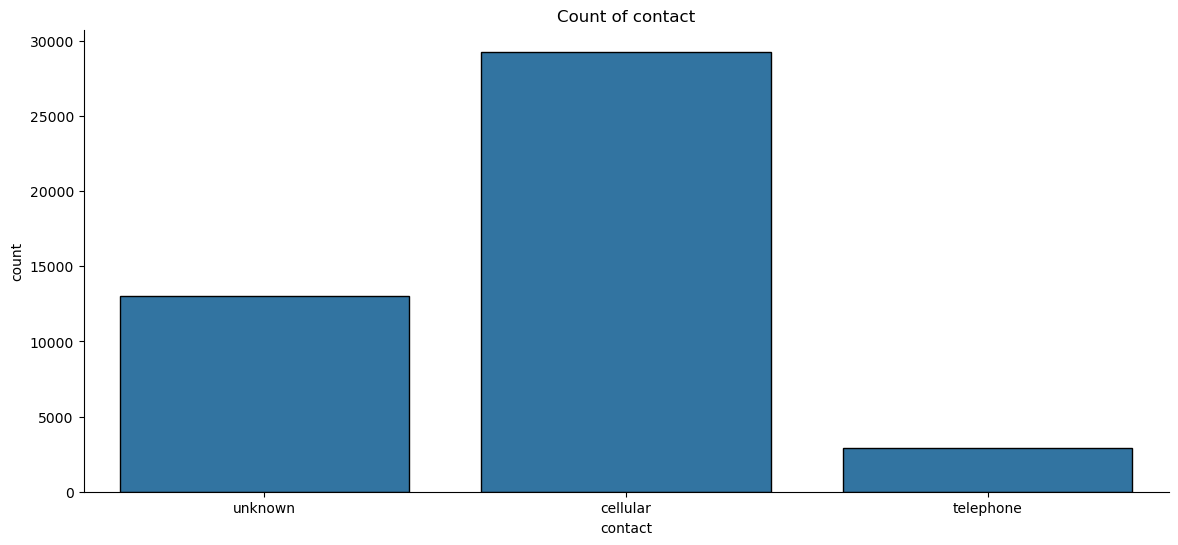

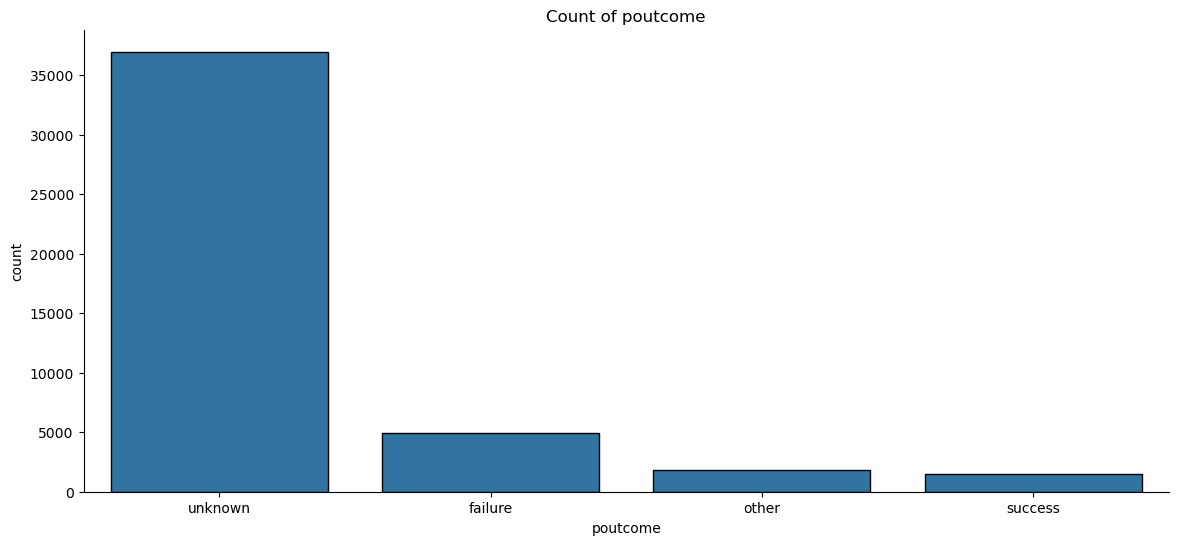

In [8]:
for column in Xtrain.columns:
    if pd.api.types.is_categorical_dtype(Xtrain[column]):
        countplot_format(data, column)

### Analýza numerických příznaků

In [9]:
def hist_box(df, cont_col, bins):
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

    sns.histplot(df[cont_col], bins=bins, kde=False, ax=ax[0])
    ax[0].set_title(f"{cont_col.capitalize()} Distribution in Dataset")
    ax[0].set_xlabel(cont_col.capitalize())
    ax[0].set_ylabel("Frequency")

    sns.boxplot(x=df[cont_col], ax=ax[1])
    ax[1].set_title(f"Box Plot of {cont_col.capitalize()} in Dataset")
    ax[1].set_xlabel(cont_col.capitalize())

    plt.tight_layout()
    plt.show()
    display(df[cont_col].describe())

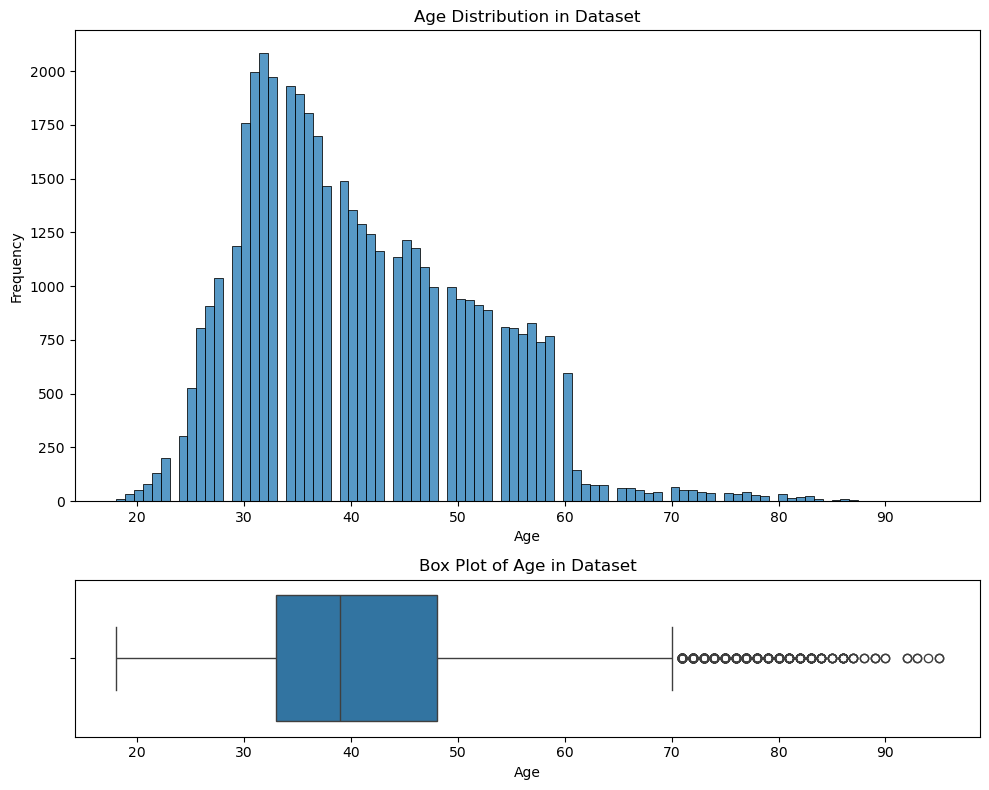

count    45211.000000
mean        40.936210
std         10.618762
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

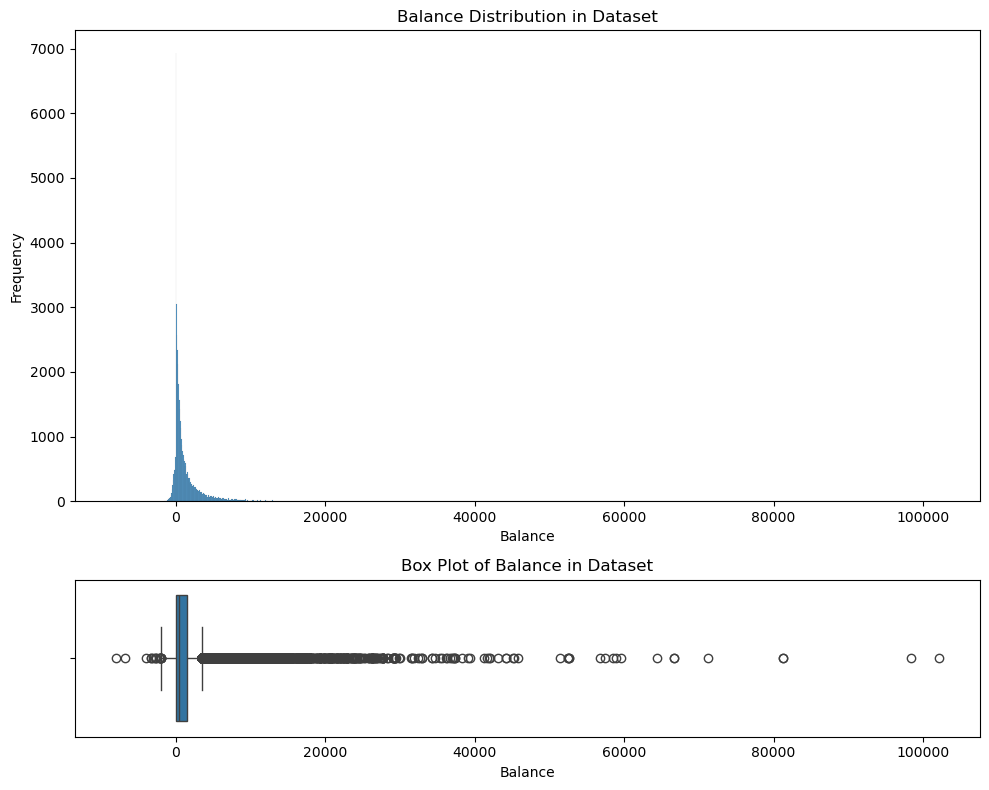

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

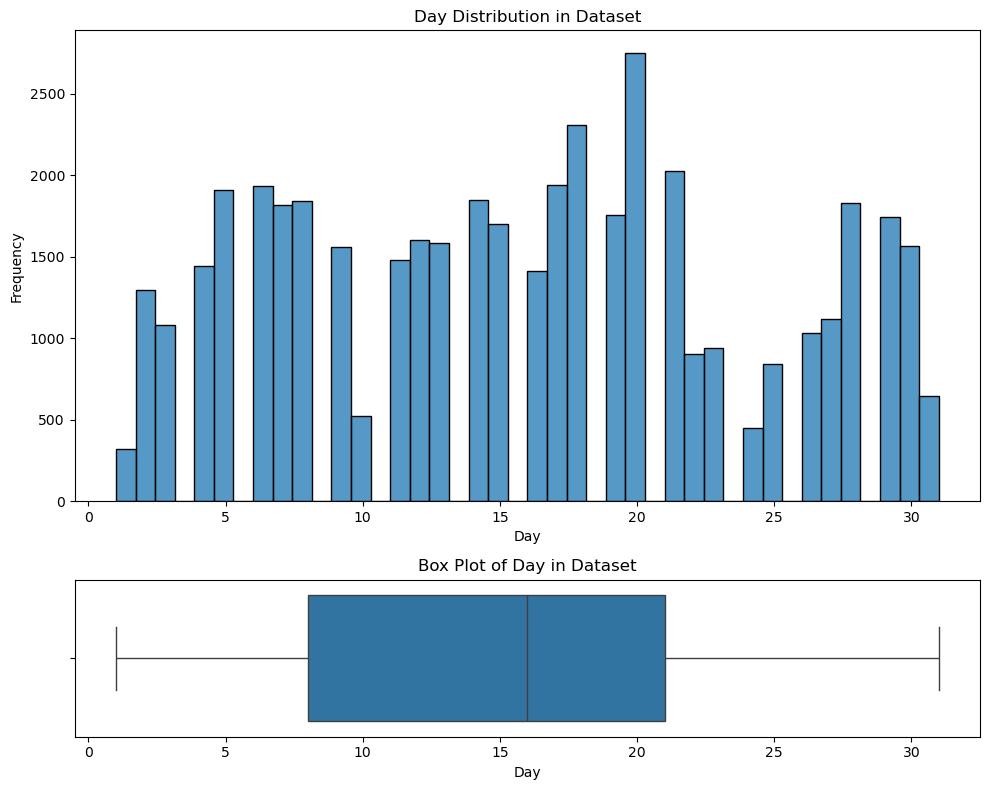

count    45211.000000
mean        15.806419
std          8.322476
min          1.000000
25%          8.000000
50%         16.000000
75%         21.000000
max         31.000000
Name: day, dtype: float64

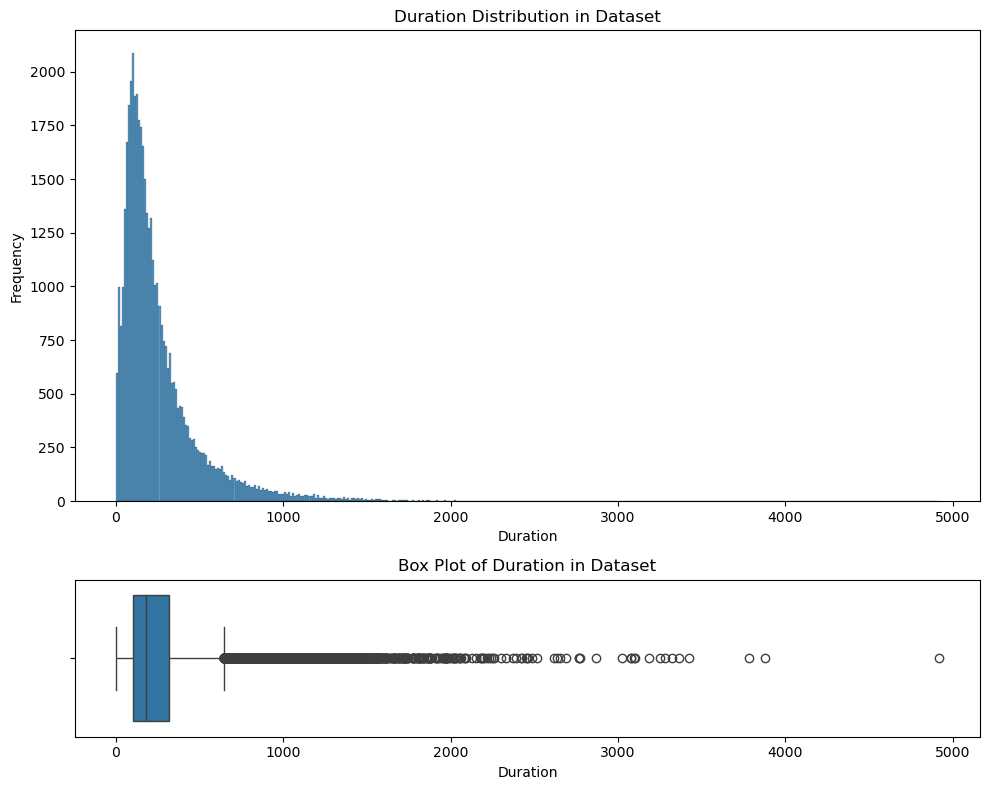

count    45211.000000
mean       258.163080
std        257.527812
min          0.000000
25%        103.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64

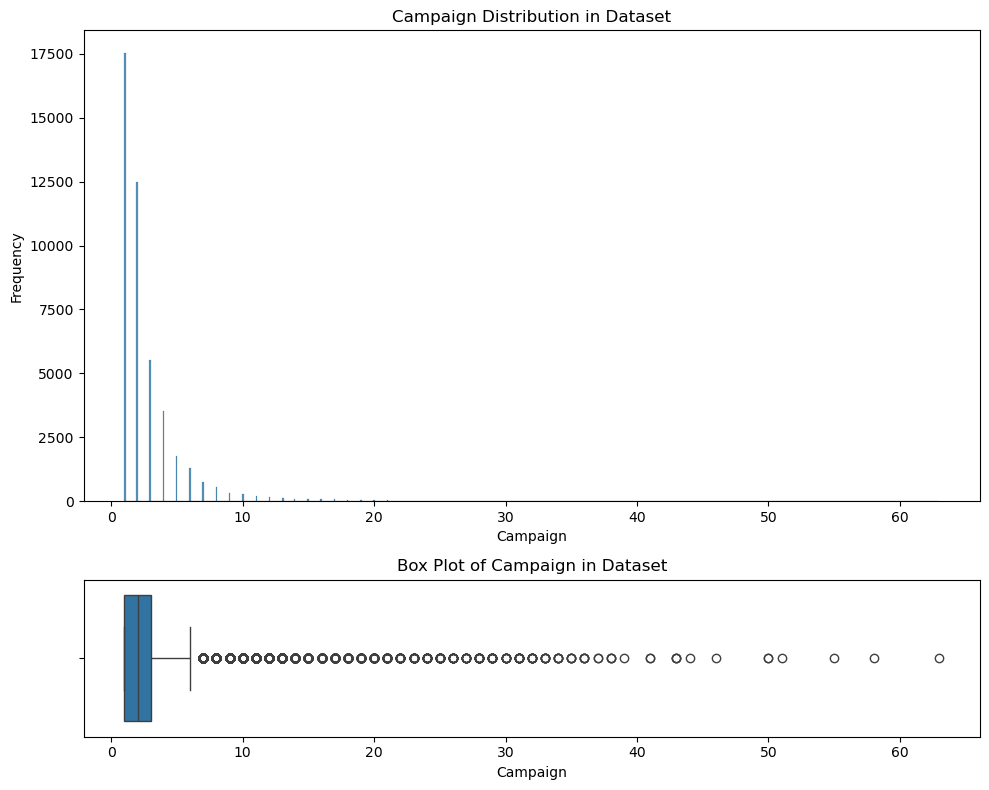

count    45211.000000
mean         2.763841
std          3.098021
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64

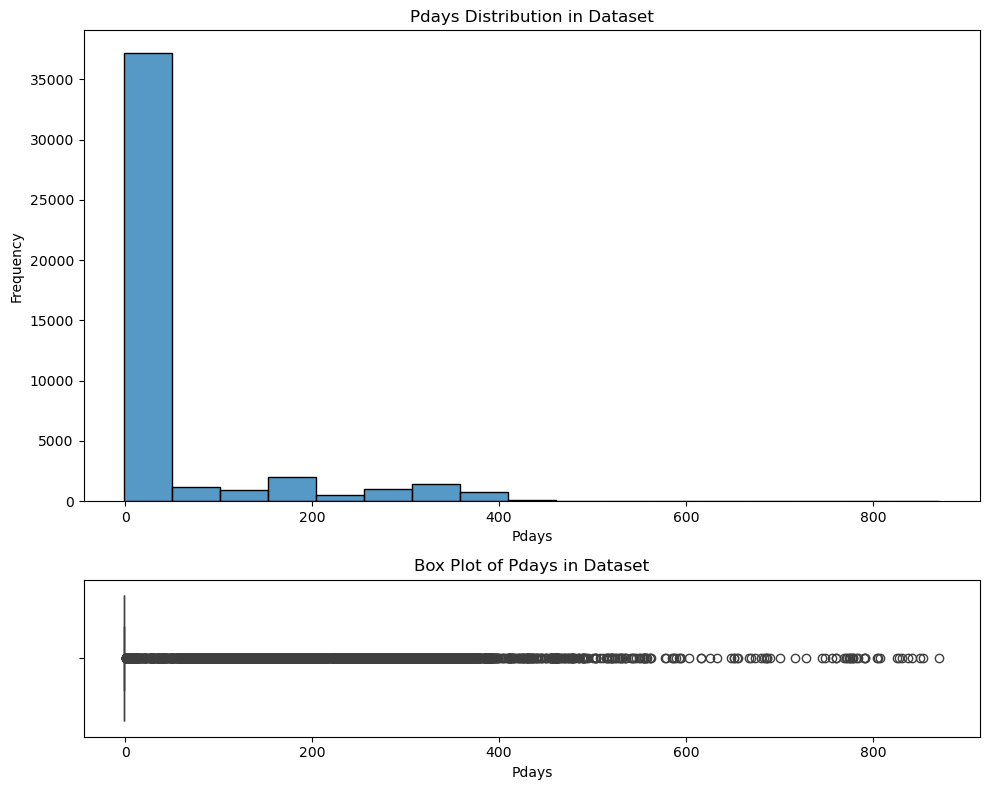

count    45211.000000
mean        40.197828
std        100.128746
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max        871.000000
Name: pdays, dtype: float64

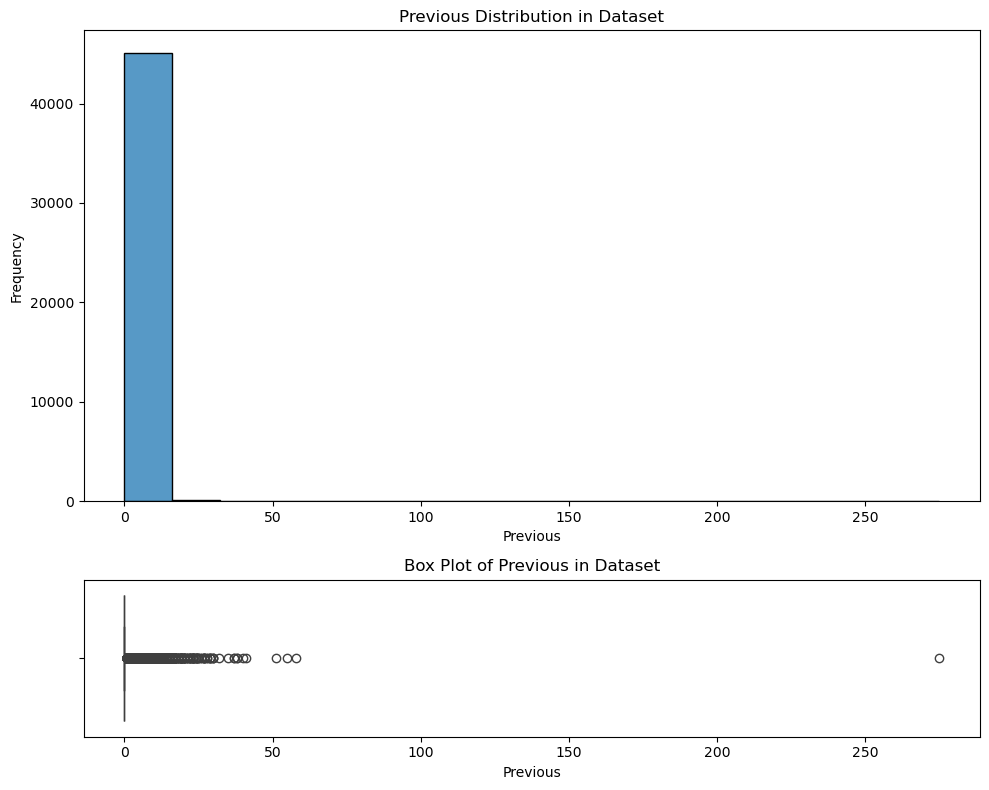

count    45211.000000
mean         0.580323
std          2.303441
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        275.000000
Name: previous, dtype: float64

In [10]:
for column in data.columns:
    if data[column].dtype == np.int64:
        hist_box(data, column, 'auto')

Všechny číselné hodnoty, jsou ve správných rozsazích. Nechybí žádné hodnoty.

## Transformace dat pro použití v modelu klasifikačního stromu

Pro příznaky, jejichž kategorie jsou yes/no převedu na numerický binární 1,0. Stejně tak i sloupec y.

Pro použití v modelu klasifikačního stromu aplikuji na kategorické příznaky one-hot encoding.

In [11]:
def binary_encode(data, columns):
    for column in columns:
        data[column] = data[column].map({'yes': 1, 'no': 0})
    return data

In [12]:
def one_hot_encode(data, cols, encoder):
    encoded_array = encoder.transform(data[cols])
    encoded_columns = encoder.get_feature_names_out(cols)
    encoded_data = pd.DataFrame(encoded_array, columns=encoded_columns, index=data.index)
    data = pd.concat([data, encoded_data], axis=1).drop(cols, axis=1)
    return data

In [13]:
def preprocess_data(train_df, val_df, test_df, colsToDrop=[]):
    datasets = [train_df, val_df, test_df]
    for i in range(len(datasets)):
        if (not datasets[i].empty):
            datasets[i] = datasets[i].drop(columns=colsToDrop)
            datasets[i] = map_months(datasets[i])
            datasets[i] = binary_encode(datasets[i], ['default', 'housing', 'loan'])
            datasets[i] = to_cat(datasets[i])
    train_df, val_df, test_df = datasets
    
    cat_cols = [column for column in train_df.columns if pd.api.types.is_categorical_dtype(train_df[column])]
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False).fit(train_df[cat_cols])

    for i in range(len(datasets)):
        datasets[i] = one_hot_encode(datasets[i], cat_cols, encoder)
    train_df, val_df, test_df = datasets
    return train_df, val_df, test_df

In [14]:
data = pd.read_csv("bank-full.csv", sep=';')
data = binary_encode(data, ['y'])
Xtrain, ytrain, Xval, yval, Xtest, ytest = splitData(data, 'y')
Xtrain, Xval, Xtest = preprocess_data(Xtrain, Xval, Xtest)

In [15]:
Xtrain.head()

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,...,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
23363,31,0,347,1,0,27,8,59,6,-1,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
7144,43,0,5172,1,0,29,5,57,3,-1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
31982,34,0,1116,1,0,13,4,120,1,262,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
11389,38,1,-1007,1,1,19,6,71,1,-1,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
22242,34,0,0,0,0,21,8,129,4,-1,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## Trénování a vizualizace modelu 

### Výběr metriky

Nejprve zjistím jestli je dataset vyvážený.

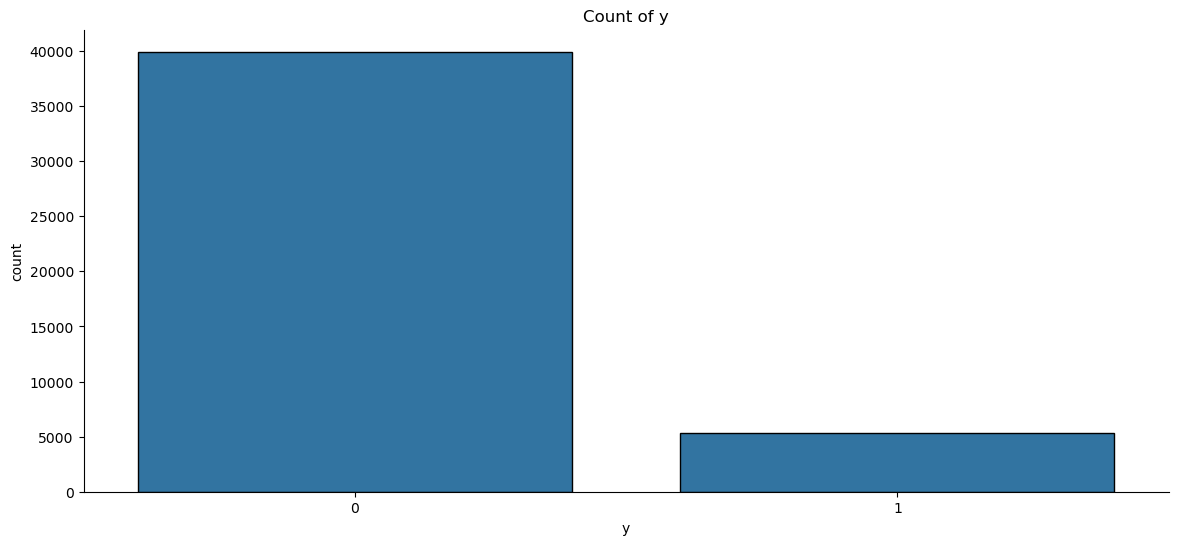

In [16]:
countplot_format(data, 'y')

Dataset není vyvážený, proto jako metriku pro výběr nejlepších hyperparametrů zvolím F1 skóre.

### Trénování a vizualizace vlivu hyperparametrů

Ladím různé kombinace maximální hloubky, kritéria a minimální počet samplů v listu a minimální počet samplů na rozdělení vnitřního uzlu. 

Vypíšu kombinaci, která měla nejlepší F1 skóre na validační množině. Tu využiji k vytvoření finálního modelu.

In [81]:
param_grid = {
    "max_depth": range(2,12),
    "min_samples_split": range(2,6),
    "min_samples_leaf": range(1,6),
}
param_comb = ParameterGrid(param_grid)

val_acc = []
train_acc = []
for params in param_comb:
    dt = DecisionTreeClassifier(**params)
    dt.fit(Xtrain, ytrain)
    val_acc.append(metrics.f1_score(yval, dt.predict(Xval)))
    train_acc.append(metrics.f1_score(ytrain, dt.predict(Xtrain)))

best_params = param_comb[np.argmax(val_acc)]
print("Best hyperparameters: ", best_params)
dt = DecisionTreeClassifier(**best_params)
dt.fit(Xtrain, ytrain)
print(
    "F1 score (train): {0:.6f}".format(
        metrics.f1_score(ytrain, dt.predict(Xtrain))
    )
)
print(
    "F1 score (validation): {0:.6f}".format(
        metrics.f1_score(yval, dt.predict(Xval))
    )
)

Best hyperparameters:  {'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 10}
F1 score (train): 0.680307
F1 score (validation): 0.497854


### Vizualizace vlivu kombinací hyperparametrů na metriku

In [68]:
df = pd.DataFrame(param_comb)
df['F1 score'] = val_acc

# Plot the parallel coordinates
fig = px.parallel_coordinates(
    df, 
    color='F1 score', 
    color_continuous_scale=px.colors.diverging.RdYlGn,
    color_continuous_midpoint=0.5
)

fig.show()

Hlavní vliv na výsledné F1 skóre měla hloubka stromu. 

### Vizualizace modelu

Využil jsem knihovnu dtreeviz, strom je poměrně rozsáhlý (hluboký). Zobrazil jsem tedy koláčové grafy jenom v listech.

In [51]:
viz = dtreeviz(
    dt, Xtrain, ytrain,
    target_name='y',
    feature_names=Xtrain.columns,
    class_names=['no', 'yes'],
    scale=1.5,
    fancy=False
)

viz

/Users/ondrej/anaconda3/envs/viz/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


## Evaluace modelu


1. zvolené hyperparametry a jejich hodnoty popsat - DONE
2. Zvolit ztrátovou funkci a pomocí které budu vyhodnocovat úspěšnost modelu = Matice záměn - DONE
3. Model vyzualizovat, pokud to lze DONE
4. Vizualizovat vliv jednotlivých kombinací hyperparametru na train a val acc, uvest nejlepsi DONE
5. **Pokud to lze** rozhodovací hranice modelu, pokud ne zdůvodnit a realizovat jinou vizualizaci s prezentací nejlepšího modelu
6. Vizualizovat úspěšnost výsledného modelu, aspoň dvě vizualizace DONE. PR krivka, ROS

### Vizualizace úspěšnosti modelu

Víme, že dataset je značně nevyvážený, proto nás bude zajímat spíše F1 scóre a precison recall křivka.

TPR = 0.4489
FNR = 0.5511
FPR = 0.0458
TNR = 0.9542
Accuracy: 0.8966
F1 Score: 0.4975


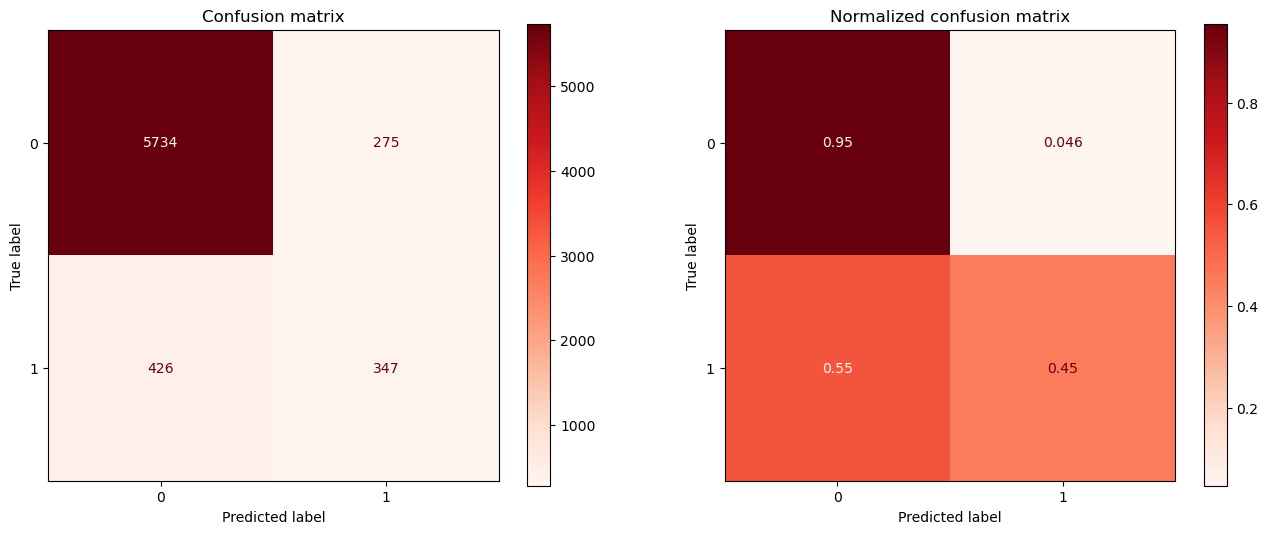

In [20]:
def show_confusion_matrices(y_real, y_pred):
    fig, axs = plt.subplots(1,2, figsize=(16,6))

    ConfusionMatrixDisplay.from_predictions(y_real, y_pred, ax=axs[0], cmap='Reds')
    ConfusionMatrixDisplay.from_predictions(y_real, y_pred, ax=axs[1], cmap='Reds', normalize='true')
    
    axs[0].grid(visible=False)
    axs[1].grid(visible=False)

    axs[0].set_title('Confusion matrix')
    axs[1].set_title('Normalized confusion matrix')


def print_metrics(ytest, ypred):
    cf = metrics.confusion_matrix(ytest, ypred)
    cf_r = metrics.confusion_matrix(ytest, ypred, normalize="true")
    
    show_confusion_matrices(ytest, ypred)
    
    print(f"TPR = {cf_r[1,1]:.4f}\nFNR = {cf_r[1,0]:.4f}\nFPR = {cf_r[0,1]:.4f}\nTNR = {cf_r[0,0]:.4f}")
    print(f"Accuracy: {metrics.accuracy_score(ytest, ypred):.4f}")
    print(f"F1 Score: {metrics.f1_score(ytest, ypred):.4f}")

print_metrics(yval, dt.predict(Xval))

Přesnost vypadá optimisticky. Nicméně F1 skóre je poměrně nízké. Model predikuje správně převážně negativní odpověď zákazníka (tj. majoritní třídu v datasetu).

In [47]:
def printROC(model, yval, Xval):
    y_pred_proba = model.predict_proba(Xval)
    p1_hat = y_pred_proba[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(yval, p1_hat)
    AUC = metrics.roc_auc_score(yval, y_pred_proba[:,1])

    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    ax.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC křivka (AUC = {AUC:.3f})")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC")
    ax.legend(loc="lower right")
    plt.show()

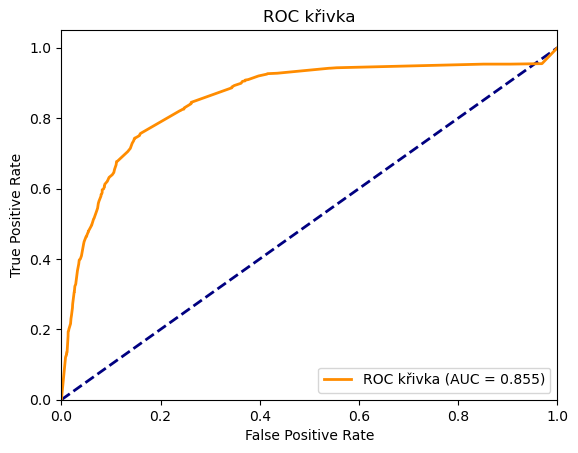

In [22]:
printROC(dt, yval, Xval)

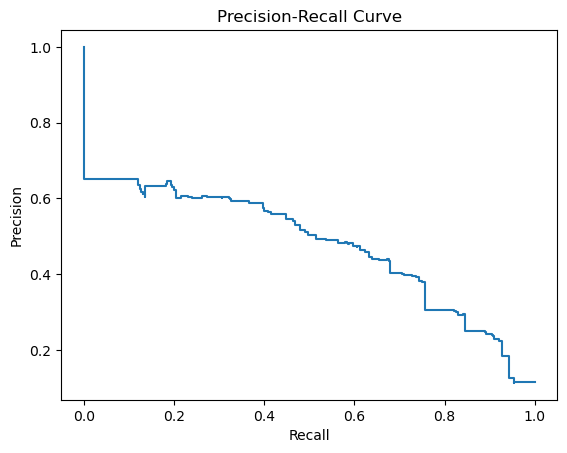

In [45]:
def printPRC(model, Xval, yval):
    y_pred = model.predict_proba(Xval)[:, 1]
    precision, recall, _ = precision_recall_curve(yval, y_pred)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.title('Precision-Recall Curve')
    plt.show()

printPRC(dt, Xval, yval)

ROC křivka vypadá optimisticky. Nicméně Precision-Recall křivka odhaluje, že schopnost modelu odhalit pozitivní případy není dobrá. 

TPR = 0.4516
FNR = 0.5484
FPR = 0.0437
TNR = 0.9563
Accuracy: 0.8949
F1 Score: 0.5113


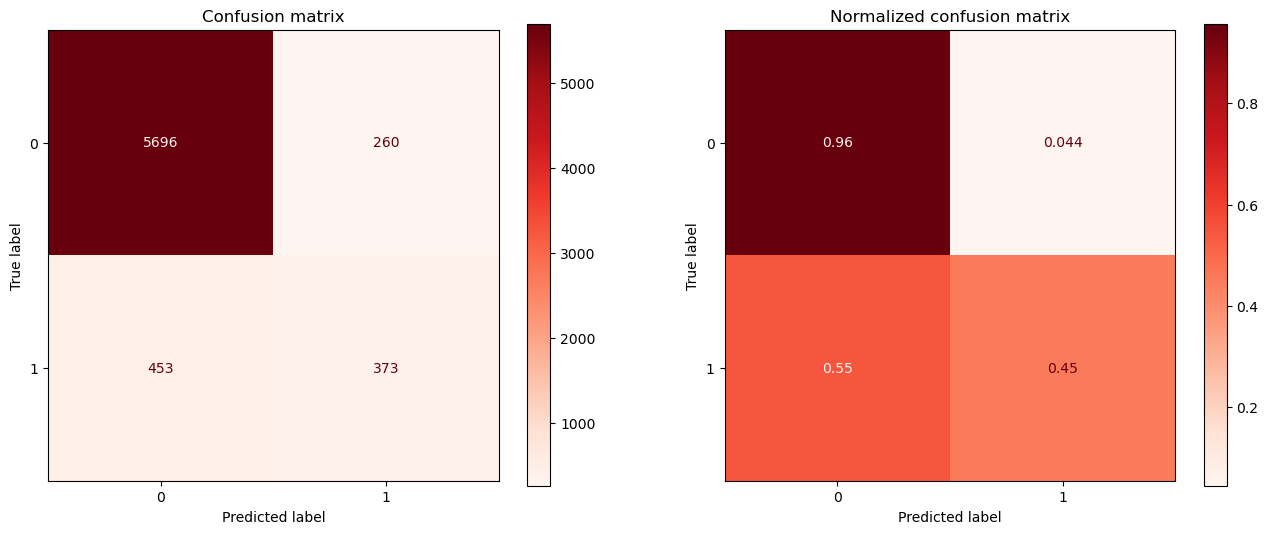

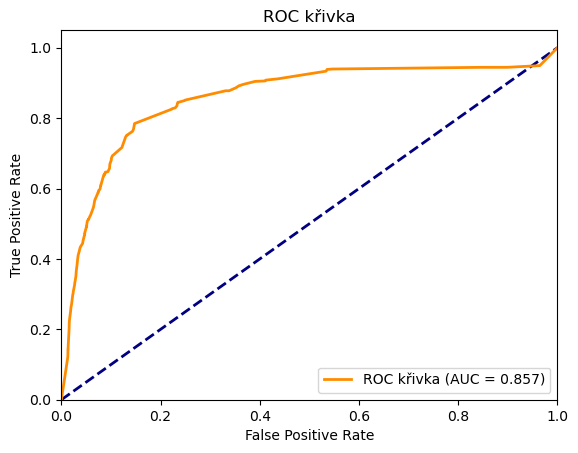

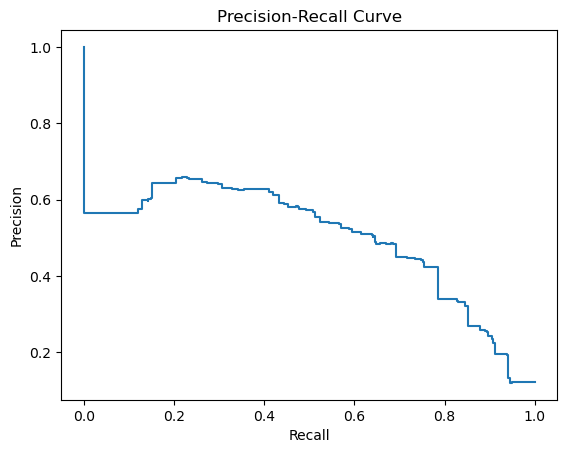

In [46]:
#Testovaci data
print_metrics(ytest, dt.predict(Xtest))
printROC(dt, ytest, Xtest)
printPRC(dt, Xtest, ytest)

## Vizualizace rozhodovací hranice modelu

Zjistím jaké příznaky jsou nejdůležitější pro rozhodování modelu.

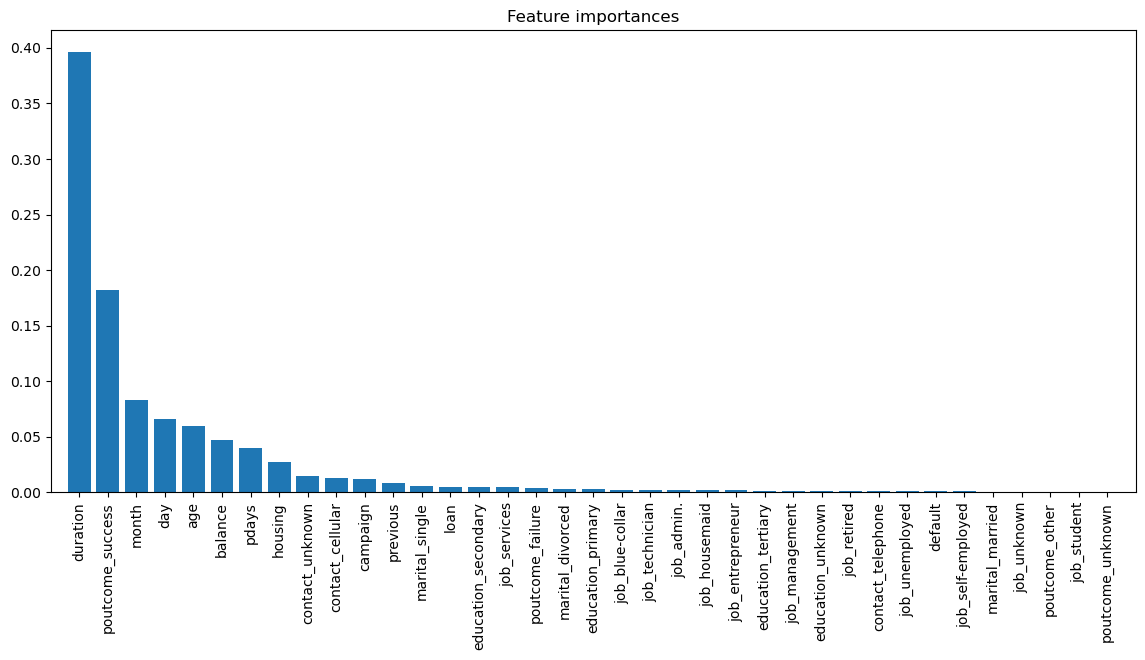

In [24]:
importances = dt.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(14, 6))
plt.title("Feature importances")
plt.bar(range(Xtrain.shape[1]), importances[indices], align="center")
plt.xticks(range(Xtrain.shape[1]), Xtrain.columns[indices], rotation=90)
plt.xlim([-1, Xtrain.shape[1]])
plt.show()